The purpose of this notebook is to show on the one hand the use of the FHIR2datset module and on the other hand the underlying functionalities of this module.

# Notebook initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
txt = os.getcwd()
txt = txt.split("/")[:-1]
parent_path = "/".join(txt)
os.chdir(parent_path)
import logging
logging.basicConfig(filename="log.txt", level=logging.INFO)

In [3]:
# os.getcwd()

In [4]:
import json
import pprint
import objectpath
import pandas as pd
from IPython.display import Markdown as md

from fhir2dataset.graph_tools import join_path
from fhir2dataset.url_builder import URLBuilder
from fhir2dataset.query import Query

In [5]:
pp = pprint.PrettyPrinter(indent=1)
fhir_api_url = 'http://hapi.fhir.org/baseR4/'
path_rules = 'data'

## Loading the example used for the tutorial

We will answer this question with the example stored in the following folder:

In [26]:
dirname = 'tests/5'

In [28]:
filename_config = 'config.json'
filename_question = 'question.md'
filename_sql_like_query = 'infos_test/sql_like_query.md'

with open(os.path.join(dirname, filename_config)) as json_file:
    config = json.load(json_file)
with open(os.path.join(dirname, filename_question), 'r') as mardown_file:
     question= mardown_file.read()
with open(os.path.join(dirname, filename_sql_like_query), 'r') as mardown_file:
    sql_like_query= mardown_file.read()

FileNotFoundError: [Errno 2] No such file or directory: 'tests/4/infos_test/sql_like_query.md'

# What's this module for? 

The module will make it possible to answer the following question knowing that the searched data are stored in a database provided with an API compliant with the FHIR standard. The data corresponding to the query will be returned in a tabular format, ideal for data analysis.

In [8]:
print(question)

Get information on Condition, AllergyIntolerance, Patient and Practitioner resources that meet all of the following conditions:

* patients were born in 1970 (associated search parameter of the resource Patient : birthdate=1970)
* they've been diagnosed allergic to Cashew nuts (associated search parameter of the resource AllergyIntolerance: code=http://snomed.info/sct|227493005)
* the source of the information about the allergy is a practioner who lives in france (associated search parameter of the resource Practitioner: address-country=france)
* these patients have already had fever (associated search parameter of the resource Condition: code=http://snomed.info/sct|386661006)


If you are familiar with SQL queries, the kind of query you would have made would have been as follows:

Note: the queries that will be made by this module are not SQL queries, they are in a way more flexible to be integrated with other services thanks to the configuration file.

In [9]:
print(sql_like_query)

SELECT patient.name.family, patient.birthDate, practitioner.name.family, practitioner.address, allergy.code.display, condition.code.coding.display, condition.severity.coding.display

FROM AllergyIntolerance as allergy
INNER JOIN Patient as patient ON allergy.patient.reference = patient.id
INNER JOIN Practitioner as practitioner ON allergy.asserter.reference = practitioner.id
INNER JOIN Condition as condition ON condition.subject.reference = patient.id

WHERE patient.birthdate gt "1970"
AND allergy.code = "http://snomed.info/sct|22749300"
AND practitioner.address-city = "paris"
AND condition.code = "http://snomed.info/sct|386661006"


# How to use this module?

### 1. First of all, the elements of the query you want to make must be translated into a json configuration file.

The configuration file for the example is therefore:

In [10]:
pp.pprint(config)

{'from': {'allergy': 'AllergyIntolerance',
          'condition': 'Condition',
          'patient': 'Patient',
          'practitioner': 'Practitioner'},
 'join': {'inner': {'allergy': {'asserter': 'practitioner',
                                'patient': 'patient'},
                    'condition': {'subject': 'patient'}}},
 'select': {'allergy': ['code.display'],
            'condition': ['code.coding.display', 'severity.coding.display'],
            'patient': ['name.family', 'birthDate'],
            'practitioner': ['name.family', 'address']},
 'where': {'allergy': {'code': 'http://snomed.info/sct|22749300'},
           'condition': {'code': 'http://snomed.info/sct|386661006'},
           'patient': {'birthdate': '1976'},
           'practitioner': {'address-city': 'paris'}}}


In [11]:
# READ OUTPUT
alias = list(config['from'].keys())[0]
resource_type = config['from'][alias]
url_fhir_doc = f"https://www.hl7.org/fhir/{resource_type.lower()}.html"
md(
    f"a. The information contained in the **'from'** allows you to specify the **FHIR type of resource** "
    f"associated with each alias.<br><br>"
    f"For example, here the alias **{alias}** is a FHIR resource "
    f"of type **{resource_type}** whose corresponding documentation can be found at the following link: [{url_fhir_doc}]({url_fhir_doc})"
)

a. The information contained in the **'from'** allows you to specify the **FHIR type of resource** associated with each alias.<br><br>For example, here the alias **allergy** is a FHIR resource of type **AllergyIntolerance** whose corresponding documentation can be found at the following link: [https://www.hl7.org/fhir/allergyintolerance.html](https://www.hl7.org/fhir/allergyintolerance.html)

In [12]:
# READ OUTPUT
data = {
    'alias linked to a parent-type resource':
    {'expression leading to a Reference type data in the json of an occurrence of a FHIR resource of the parent type': 'alias linked to a child-type resource'}}

parent_alias = list(config['join'].keys())[0]
expression = list(config['join'][parent_alias].keys())[0]
child_alias = config['join'][parent_alias][expression]
data_example = { parent_alias: {expression: child_alias}}

url_fhir_doc=f"https://www.hl7.org/fhir/{parent_alias.lower()}.html#resource"
md(
    f"b. The information contained in the **'join'** allows you to specify "
    f"**how the aliases are linked together**.<br><br>"
    f"Joins are of the parent-child type, i.e. in a resource instance of the "
    f"parent type there is a [reference](https://www.hl7.org/fhir/references.html#Reference) to an instance of the child resource type. "
    f"This will result in the following structure in the configuration file:<br><br>"
    f"{data}<br><br>"
    f"Example ([FHIR doc associated]({url_fhir_doc})):<br>"
    f"{data_example}<br><br>"
    f"Note: each alias must at least be linked to another alias."
)

b. The information contained in the **'join'** allows you to specify **how the aliases are linked together**.<br><br>Joins are of the parent-child type, i.e. in a resource instance of the parent type there is a [reference](https://www.hl7.org/fhir/references.html#Reference) to an instance of the child resource type. This will result in the following structure in the configuration file:<br><br>{'alias linked to a parent-type resource': {'expression leading to a Reference type data in the json of an occurrence of a FHIR resource of the parent type': 'alias linked to a child-type resource'}}<br><br>Example ([FHIR doc associated](https://www.hl7.org/fhir/inner.html#resource)):<br>{'inner': {'condition': {'subject': 'patient'}}}<br><br>Note: each alias must at least be linked to another alias.

In [13]:
# READ OUTPUT
alias = list(config['where'].keys())[0]
url_fhir_doc=f"https://www.hl7.org/fhir/{alias.lower()}.html#search"

data = {
    'alias': {'search param': {'prefix': 'value'}}
}
data_default = {
    'alias': {'search param': 'value'}
}
md(
    f"c. The information contained in the **'where'** allows you to specify the **conditions "
    f"on the search parameters**.<br><br>"
    f"For example, the search parameters that the alias {alias} can have are specified "
    f"[here]({url_fhir_doc}) in the FHIR doc."
    f"This will result in the following structure in the configuration file:<br>"
    f"{data}<br><br>"
    f"The prefixes that can be used are those specified [here](https://www.hl7.org/fhir/search.html#prefix) in the FHIR doc."
    f"It is also possible to use a simplified structure that assumes that the prefix used is eq:<br>"
    f"{data_default}<br><br>"
)

c. The information contained in the **'where'** allows you to specify the **conditions on the search parameters**.<br><br>For example, the search parameters that the alias patient can have are specified [here](https://www.hl7.org/fhir/patient.html#search) in the FHIR doc.This will result in the following structure in the configuration file:<br>{'alias': {'search param': {'prefix': 'value'}}}<br><br>The prefixes that can be used are those specified [here](https://www.hl7.org/fhir/search.html#prefix) in the FHIR doc.It is also possible to use a simplified structure that assumes that the prefix used is eq:<br>{'alias': {'search param': 'value'}}<br><br>

In [14]:
# READ OUTPUT
alias = None
expressions = None
url_fhir_doc = None
resource = None
for key in config['select'].keys():
    if key != 'count':
        alias = key
        expressions = config['select'][key]
        resource = config['from'][key]
        url_fhir_doc = f"https://www.hl7.org/fhir/{resource.lower()}.html#resource"
        break
md(
    f"d. The information contained in the **'select'** allows you to specify the elements that "
    f"must be present in the output table.<br><br>"
    f"For example, for the instances corresponding to the alias {alias} it will be necessary to "
    f"retrieve the information in the JSON contained after the expression(s) {expressions}. "
    f"It can be observed that these expressions correspond well to the FHIR specifications of "
    f"the associated [{resource} resource](url_fhir_doc)."
)

d. The information contained in the **'select'** allows you to specify the elements that must be present in the output table.<br><br>For example, for the instances corresponding to the alias patient it will be necessary to retrieve the information in the JSON contained after the expression(s) ['name.family', 'birthDate']. It can be observed that these expressions correspond well to the FHIR specifications of the associated [Patient resource](url_fhir_doc).

### 2. Initilize an instance of the **Query class**

3 things are needed to initialize this instance:
* fhir_api_url: the Service Base URL (e.g. [http://hapi.fhir.org/baseR4/](http://hapi.fhir.org/baseR4/))
* path_rules : the path to the folder containing the CapabilityStatement and SearchParameters file (a future feature may allow these documents to be loaded directly on the api)
* config : a json file in the previously described format

In [15]:
query = Query(fhir_api_url)
query.from_config(config)

### 3. Request the execution of the query

In [16]:
query.execute()

#### What does this function do?

##### 3.1 Storing info from the config file in a graph

Below we can see a visualization of the relationships that have been established between the aliases.

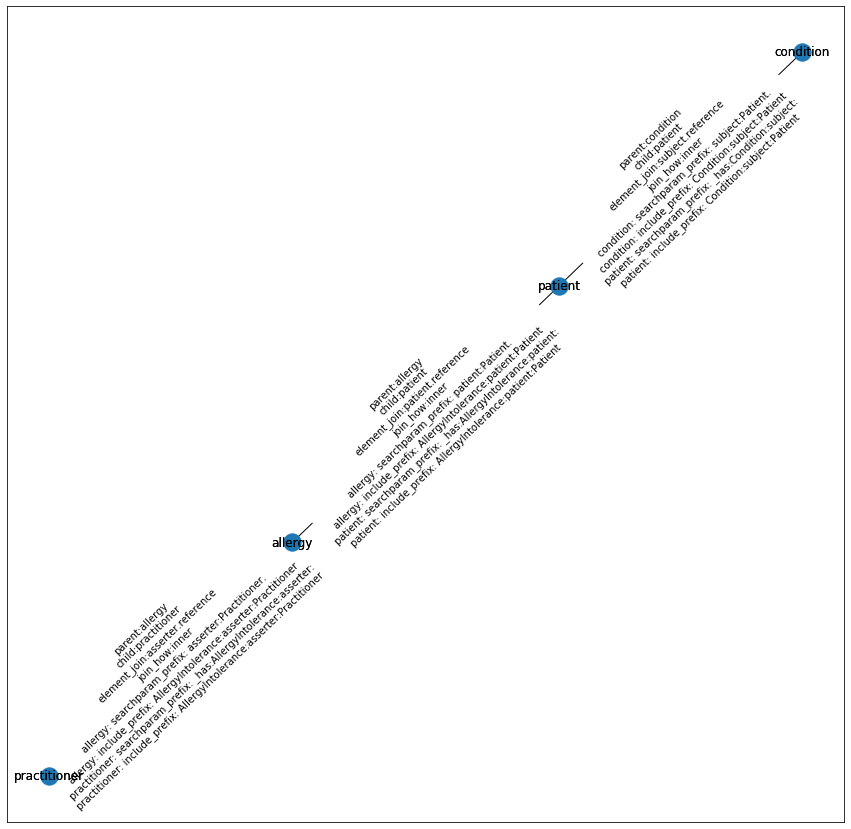

In [17]:
query.graph_query.draw_relations()

In [18]:
edge = list(query.graph_query.resources_alias_graph.edges)[0]
edge_info = query.graph_query.resources_alias_graph.edges[edge]

md(
    f"Each edge contains a lot of information. We will illustrate this by the content of the edge between **{edge[0]}** and **{edge[1]}**.<br>"
    f" - the alias of the **parent** resource: *{edge_info['parent']}*<br>"
    f" - the alias of the **child** resource: *{edge_info['child']}*<br>"
    f" - the **expression** in an instance of *{edge_info['parent']}* resource-type which must indicate a reference identical to the id of *{edge_info['child']}* resource-type: *{edge_info['element_join']}*<br>"
    f" - the **prefix** that must be added **in front of a param search** in the url of a query sent to a FHIR API if the request is made from an *{edge[0]}* resource-type but the search parameter relates to a *{edge[1]}* resource-type : "
    f"*{edge_info[edge[0]]['searchparam_prefix']}*<br>"
    f" - also the reverse **prefix** from a *{edge[1]}* resource-type to a *{edge[0]}* resource-type : "
    f"*{edge_info[edge[1]]['searchparam_prefix']}*<br>"
    "the other information is not useful for the moment"
)

Each edge contains a lot of information. We will illustrate this by the content of the edge between **allergy** and **patient**.<br> - the alias of the **parent** resource: *allergy*<br> - the alias of the **child** resource: *patient*<br> - the **expression** in an instance of *allergy* resource-type which must indicate a reference identical to the id of *patient* resource-type: *patient.reference*<br> - the **prefix** that must be added **in front of a param search** in the url of a query sent to a FHIR API if the request is made from an *allergy* resource-type but the search parameter relates to a *patient* resource-type : *patient:Patient.*<br> - also the reverse **prefix** from a *patient* resource-type to a *allergy* resource-type : *_has:AllergyIntolerance:patient:*<br>the other information is not useful for the moment

Each node also contains several pieces of information. This information can be found in the dictionary: *query.graph_query.resources_alias_info*

In [19]:
pp.pprint(query.graph_query.resources_alias_info)

{'allergy': {'count': False,
             'elements': {'additional_resource': ['id'],
                          'additional_root': [],
                          'join': ['patient.reference', 'asserter.reference'],
                          'select': ['code.display'],
                          'where': ['reaction.substance']},
             'elements_concat_type': {'asserter.reference': 'row',
                                      'code.display': 'cell',
                                      'id': 'row',
                                      'patient.reference': 'row',
                                      'reaction.substance': 'cell'},
             'resource_type': 'AllergyIntolerance',
             'search_parameters': {'code': {'prefix': None,
                                            'value': 'http://snomed.info/sct|22749300'}}},
 'condition': {'count': False,
               'elements': {'additional_resource': ['id'],
                            'additional_root': [],
             

In [20]:
node = list(query.graph_query.resources_alias_info.keys())[0]
node_info = query.graph_query.resources_alias_info[node]
md(
    f"For example, node *{node}* contains the following information: <br>"
    f" - the **type of the associated resource**: *{node_info['resource_type']}*<br>"
    f" - the **expressions leading to the elements** to be retrieved in the json format of the instances corresponding to the query: *{node_info['elements']}*<br>"
    f" - the **search parameters under constraints** for this alias: *{node_info['search_parameters']}*<br>"
)

For example, node *allergy* contains the following information: <br> - the **type of the associated resource**: *AllergyIntolerance*<br> - the **expressions leading to the elements** to be retrieved in the json format of the instances corresponding to the query: *{'select': ['code.display'], 'additional_resource': ['id'], 'additional_root': [], 'where': ['reaction.substance'], 'join': ['patient.reference', 'asserter.reference']}*<br> - the **search parameters under constraints** for this alias: *{'code': {'prefix': None, 'value': 'http://snomed.info/sct|22749300'}}*<br>

##### 3.2 Making calls to the api for each node of the graph

In [21]:
resource_alias = list(query.graph_query.resources_alias_info.keys())[0]

In [22]:
print(f"The url queries that are made for each nodes are:")
for resource_alias in query.graph_query.resources_alias_info.keys():
    url_builder = URLBuilder(
                    fhir_api_url=fhir_api_url,
                    query_graph=query.graph_query,
                    main_resource_alias=resource_alias,
                )
    print(f" - for {resource_alias} node is {url_builder.search_query_url}")

The url queries that are made for each nodes are:
 - for allergy node is http://hapi.fhir.org/baseR4/AllergyIntolerance?code=http%3A%2F%2Fsnomed.info%2Fsct%7C22749300
 - for patient node is http://hapi.fhir.org/baseR4/Patient?birthdate=1976
 - for practitioner node is http://hapi.fhir.org/baseR4/Practitioner?address-city=paris
 - for condition node is http://hapi.fhir.org/baseR4/Condition?code=http%3A%2F%2Fsnomed.info%2Fsct%7C386661006


##### 3.3 Storing query results in multiple dataframes (1 dataframe per alias)

In [23]:
for _,df in query.dataframes.items():
    display(df.head(5))

,allergy:id,allergy:code.display,allergy:reaction.substance,allergy:patient.reference,allergy:asserter.reference
0,AllergyIntolerance/frt4,[None],[{'coding': [{'system': 'http://www.nlm.nih.go...,Patient/frt2,Practitioner/frt1


,patient:id,patient:name.family,patient:birthDate
0,Patient/738,[Wayne],[1976-10-24]
0,Patient/30647,[Rakel],[1976-07-16]
0,Patient/31060,[Viki],[1976-05-08]
0,Patient/52866,[Luiz Fernando Bernardes Ribeiro],[1976-05-04]
0,Patient/AMWL-5003,[Smith],[1976-12-12]


,practitioner:id,practitioner:name.family,practitioner:address,practitioner:address.city
0,Practitioner/100171,"[DUJARDIN, DUJARDIN]",[{'extension': [{'url': 'http://www.interopsan...,[Paris 13e Arrondissement]
0,Practitioner/frt1,[Careful],"[{'use': 'home', 'line': ['1 blv st michel'], ...",[Paris]
0,Practitioner/besta3,[Careful],"[{'use': 'home', 'line': ['1 blv st michel'], ...",[Paris]
0,Practitioner/besta2,[Green],"[{'use': 'home', 'line': ['1 blv st michel'], ...",[Paris]


,condition:id,condition:code.coding.display,condition:severity.coding.display,condition:code,condition:subject.reference
0,Condition/39391,[Fever],[Mild],[{'coding': [{'system': 'http://snomed.info/sc...,Patient/1201
0,Condition/39393,[Fever],[Mild],[{'coding': [{'system': 'http://snomed.info/sc...,Patient/1202
0,Condition/39398,[Severe Cardiac Arrest],[Severe],[{'coding': [{'system': 'http://snomed.info/sc...,Patient/1203
0,Condition/39734,[Fever],[Mild],[{'coding': [{'system': 'http://snomed.info/sc...,Patient/1202
0,Condition/39735,[Fever],[Mild],[{'coding': [{'system': 'http://snomed.info/sc...,Patient/1200


##### 3.4 Joining the dataframes by following an eulerian path in the graph

The dataframes of each alias will be linked in the following order.
This order corresponds to a Eulerian path in the query graph and thus guarantees that joins between the main dataframe (left alias) and the new dataframe (right alias) will be possible.

In [24]:
pp.pprint(join_path(query.graph_query.resources_alias_graph))

[('allergy', 'practitioner'), ('allergy', 'patient'), ('patient', 'condition')]



### Display the result of the query

In [25]:
df = query.main_dataframe
df

,allergy:code.display,patient:name.family,patient:birthDate,practitioner:name.family,practitioner:address,condition:code.coding.display,condition:severity.coding.display
0,[None],[Smith],[1976-01-01],[Careful],"[{'use': 'home', 'line': ['1 blv st michel'], ...",[Cashew nuts],[Mild]


# Save a lighter version of this notebook

In the terminal run:
```
jupyter nbconvert tutorials_generator.ipynb
```